We further modularize `DataLoader` to accept a batching method that uses random sampling instead of linear iteration.

In [1]:
from fastai.vision.all import *


We encapsulate this into a `Sampler` class that is passed into dataloader.

It can be initialized with or without a `shuffle` parameter, which sets a `.shuffle` property; during iterator creation, if set, the indices yielded by the iterator will be randomized.

In [2]:
class Sampler():
    def __init__(self, ds, shuffle=False):
        self.n, self.shuffle = len(ds), shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle:
            random.shuffle(res)
        return iter(res)


In [3]:
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]


In [4]:
pickle_path = URLs.path('mnist_png')/'mnist_png.pkl'
path = untar_data(URLs.MNIST)/'training'

if not pickle_path.exists():
    pickle_path.parent.mkdir(parents=True, exist_ok=True)
    ds = DataBlock(
        blocks = (ImageBlock(PILImageBW), CategoryBlock),
        get_items = get_image_files,
        get_y = parent_label,
        splitter = RandomSplitter(1/6, seed=0)
    ).datasets(path)

    xs, ys = zip(*ds.train, *ds.valid)
    xs = np.stack(L(map(lambda x: np.array(x, dtype=np.float32).reshape(-1), xs))) / 255.
    ys = np.array(ys, dtype=np.int64)

    x_train, x_valid = xs[:len(ds.train)], xs[len(ds.train):]
    y_train, y_valid = ys[:len(ds.train)], ys[len(ds.train):]

    save_pickle(pickle_path, [x_train, y_train, x_valid, y_valid])

    del ds, xs, ys, x_train, y_train, x_valid, y_valid

x_train, y_train, x_valid, y_valid = map(tensor, load_pickle(pickle_path))


In [5]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)


In [6]:
nss = Sampler(train_ds)
ss = Sampler(train_ds, shuffle=True)

Some access examples:

In [7]:
for idx, no, so in zip(range(5), nss, ss):
    if idx >= 5:
        break
    print(no, so)

0 30261
1 19308
2 27885
3 14440
4 37394


In [8]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False):
        store_attr()
    def __iter__(self):
        yield from chunked(
            iter(self.sampler), self.bs, drop_last=self.drop_last
        )

In [9]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28 * 28)
assert yb.shape == (5,)
xb, yb


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([3, 8, 7, 2, 8]))

In [10]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

bs = 50                # batch size

lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

layers = lambda: [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

def get_model():
    model = nn.Sequential(*layers())
    return model, torch.optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()


Our `fit` function is then revised to the following.

In [11]:
loss_func = F.cross_entropy
def accuracy(out, yb):
    return (out.argmax(dim=1) == yb).float().mean()
def report(loss, preds, yb):
    print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

def fit(model, opt, loss_func):
    for epoch in range(epochs):
        for i in range(0, n, bs):
            xb, yb = train_ds[i:min(n, i + bs)]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

fit(model, opt, loss_func)

0.20, 0.94
0.20, 0.98
0.21, 0.96


We now define a `DataLoader` that abstracts the generation of batches from the training corpus.

In [12]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds, self.bs = ds, bs

    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i + self.bs]


In [13]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)


We now first demonstrate how each batch looks like.

In [14]:
xb, yb = next(iter(valid_dl))
xb.shape, yb


(torch.Size([50, 784]),
 tensor([6, 5, 1, 1, 3, 8, 5, 2, 9, 5, 6, 5, 1, 1, 4, 2, 0, 0, 0, 9, 2, 6, 6, 8,
         9, 3, 4, 7, 3, 9, 0, 1, 0, 8, 0, 7, 0, 1, 3, 2, 1, 3, 0, 4, 8, 8, 3, 5,
         8, 0]))

tensor(6)

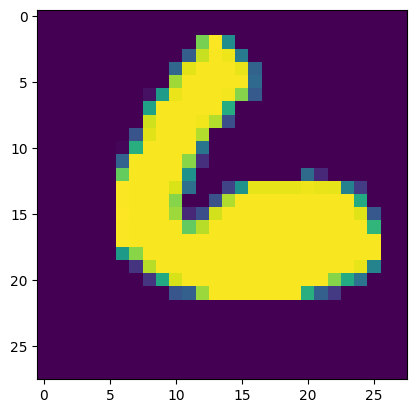

In [15]:
plt.imshow(xb[0].view(28,28))
yb[0]


And our `fit` function now becomes as follows.

In [16]:
def fit(train_dl, model, opt, loss_func):
    for _ in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)


In [17]:
model, opt = get_model()
fit(train_dl, model, opt, loss_func)
loss_func(model(xb), yb), accuracy(model(xb), yb)


0.25, 0.94
0.27, 0.96
0.25, 0.96


(tensor(0.1914, grad_fn=<NllLossBackward0>), tensor(0.9600))